In [129]:
import lsst.daf.butler as daf_butler
import numpy as np
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
from lsst.geom import SpherePoint,Angle
import astropy.units as u
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = -1
afwDisplay.setDefaultBackend("matplotlib")

def coordToPix(wcs,ra,dec):
    spherePt = SpherePoint(Angle(ra*np.pi/180),Angle(dec*np.pi/180))
    return wcs.skyToPixel(spherePt)

In [34]:
collections=["u/elhoward/TOO/0725J","u/rea3/test_0725J_v10/20250729T163637Z","u/elhoward/TOO/0725J/MMADS_candidates","LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157","u/elhoward/TOO/0725J/DESGW_candidates_v2","u/elhoward/TOO/0725J/test",
             "u/elhoward/TOO/0725J/test/doSubtractBackground",
             "u/elhoward/TOO/0725J/test/allowKernelSourceDetection"]

repo="embargo_new"

In [35]:
MyBut = daf_butler.Butler(repo,collections=collections)

In [36]:
finalVisits = []
for k in np.arange(2025072800099,2025072800159):
    if int(str(k)[-1])!=9:
        finalVisits.append(k)

In [37]:
detector = 25
visit = 2025072800145

In [38]:
# MyBut.registry.queryCollections("*ightly*20250728*")

In [39]:
diffRefs = list(MyBut.query_datasets("difference_image",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
tempRefs = list(MyBut.query_datasets("template_matched",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
searchRefs = list(MyBut.query_datasets("preliminary_visit_image",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))

In [41]:
diff = MyBut.get(diffRefs[0])
temp = MyBut.get(tempRefs[0])
search = MyBut.get(searchRefs[0])

In [42]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 

In [133]:
center_ra = 234.75
center_dec = -36.4
rad = u.Quantity(.5, u.deg)
cols = ['ra', 'dec', 'pmra',"pmdec"]

In [134]:
coord = SkyCoord(ra=center_ra, dec=center_dec, unit=(u.degree, u.degree), frame='icrs')
r = Gaia.query_object_async(coordinate=coord, height=rad,width=rad, columns=cols)

INFO: Query finished. [astroquery.utils.tap.core]


In [135]:
gaia_table = r.to_pandas()

relRows = []

for __, row in gaia_table.iterrows():
    if not np.isnan(row[["ra","dec","pmra","pmdec"]].values).any():
        relRows.append(row[["ra","dec","pmra","pmdec"]])

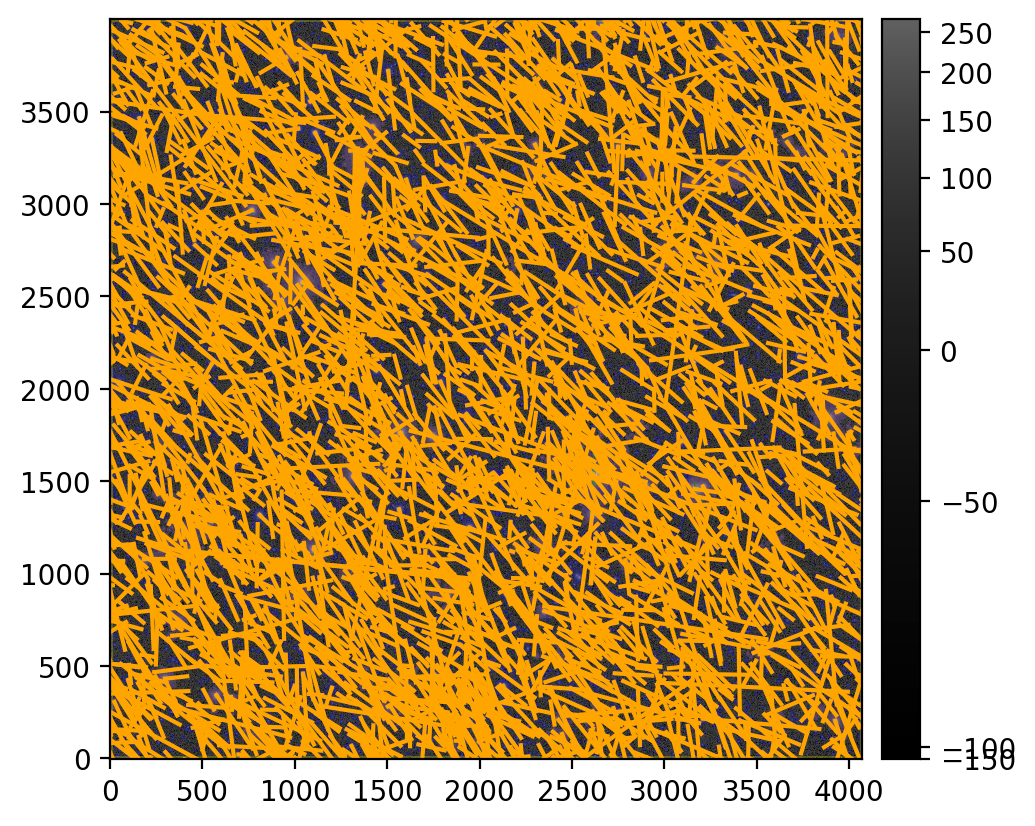

In [136]:
display = afwDisplay.Display(frame=0,dpi=200)
display.scale('asinh', 'zscale')
display.image(search)

scale=0.002
thisWCS = search.getWcs()
with display.Buffering():
    for record in relRows:
        start = coordToPix(thisWCS,record["ra"],record["dec"])
        display.dot("o",start[0],start[1],ctype="orange")
        end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
        display.line([start,end], ctype='orange')

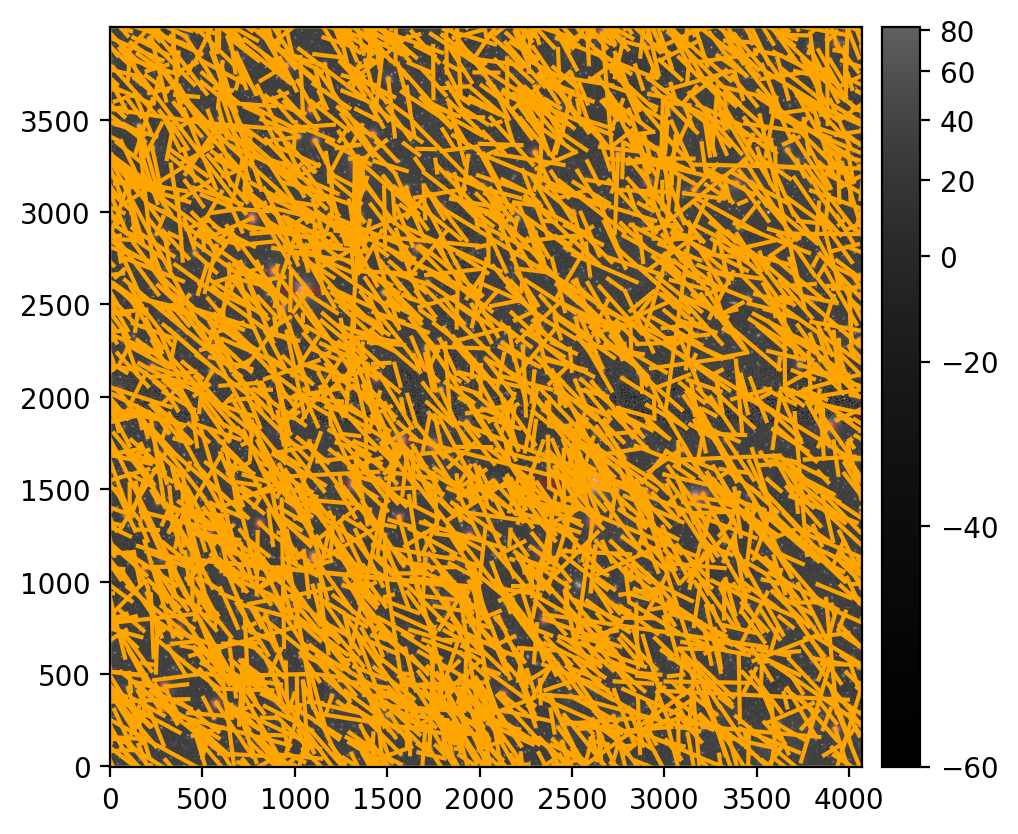

In [139]:
display = afwDisplay.Display(frame=1,dpi=200)
display.scale('asinh', 'zscale')
display.image(temp)

scale=0.002
thisWCS = temp.getWcs()
with display.Buffering():
    for record in relRows:
        start = coordToPix(thisWCS,record["ra"],record["dec"])
        display.dot("o",start[0],start[1],ctype="orange")
        end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
        display.line([start,end], ctype='orange')

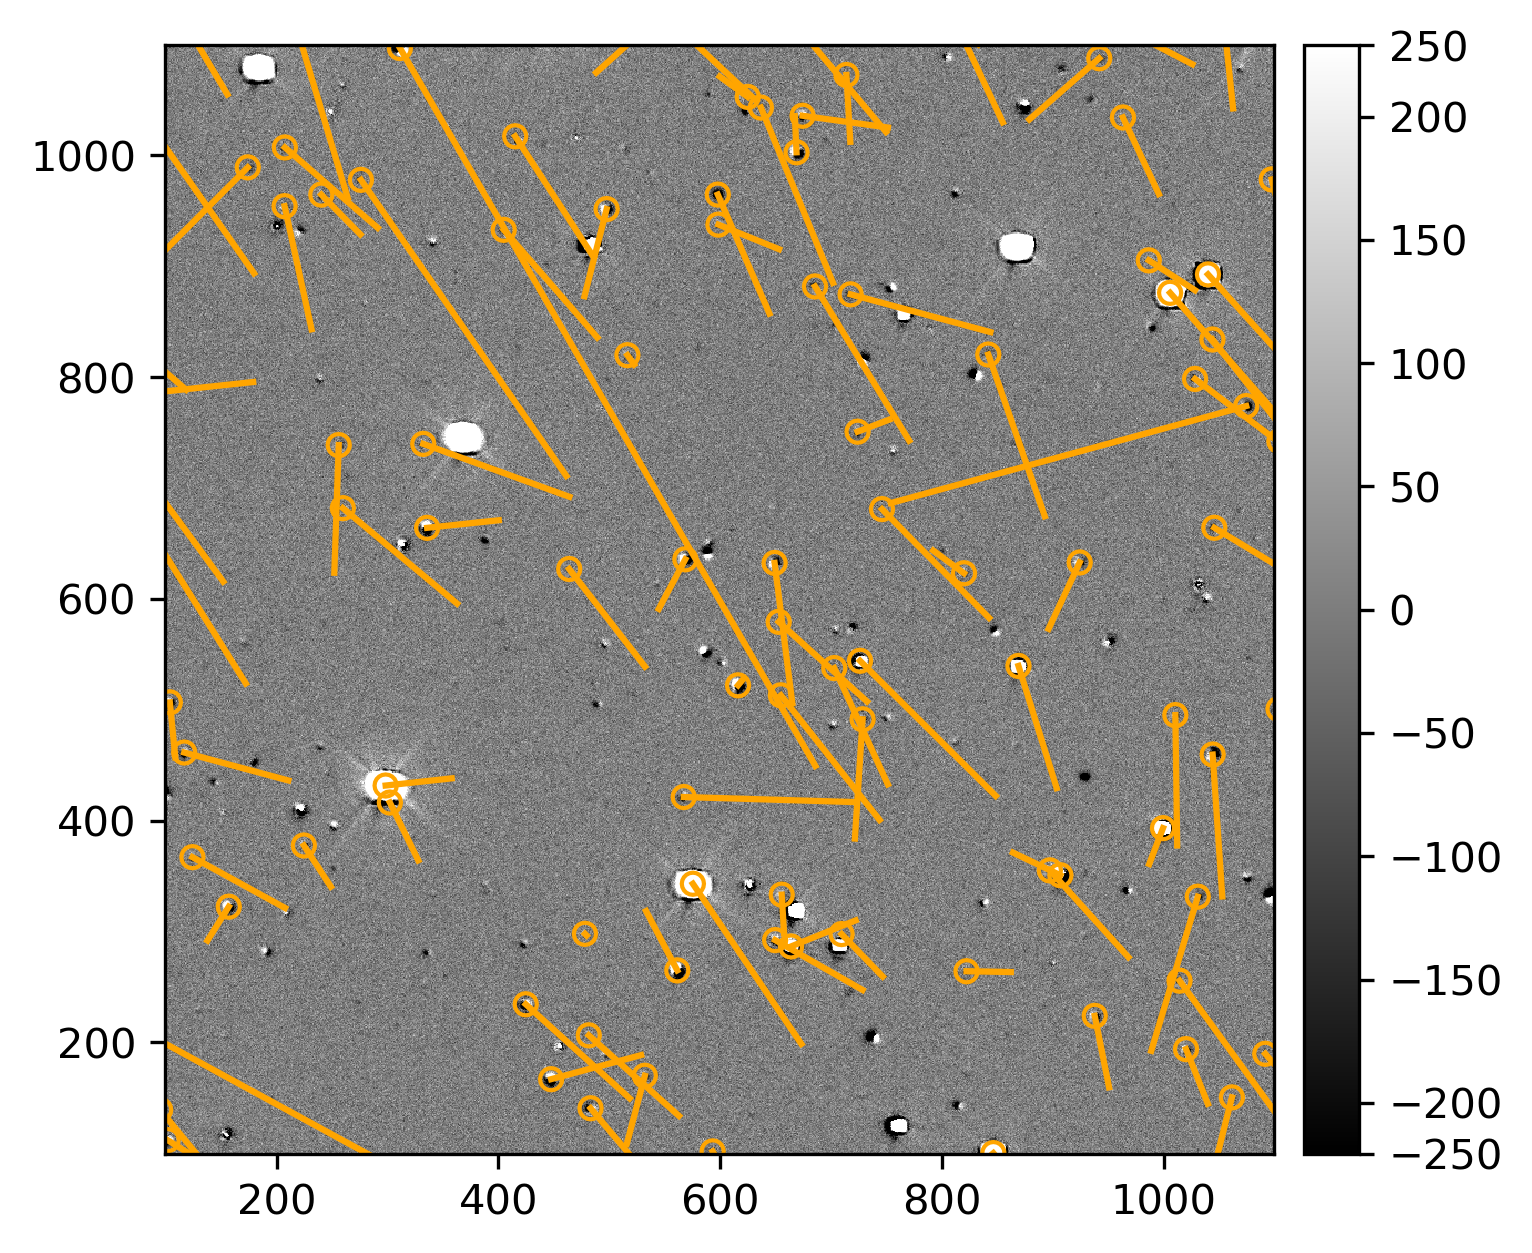

In [167]:
display = afwDisplay.Display(frame=2,dpi=300)
display.setMaskTransparency(100)
display.scale('linear', 'zscale')
display.image(diff[100:1100,100:1100])

scale=0.001
thisWCS = diff.getWcs()
with display.Buffering():
    for record in relRows[::2]:
        start = coordToPix(thisWCS,record["ra"],record["dec"])
        display.dot("o",start[0],start[1],size=10,ctype="orange")
        end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
        end1 = coordToPix(thisWCS,record["ra"]+0.1*scale*record["pmra"],record["dec"]+0.1*scale*record["pmdec"])
        display.line([start,end], ctype='orange')